<br>
<h2 style = "font-size:40px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> Celebrity Face Recognition using VGGFace Model </h2> 
<br>

<a id = '0'></a>
<h2 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #007580; color : #fed049; border-radius: 5px 5px; text-align:center; font-weight: bold" >Table of Contents</h2> 

1. [Overview](#1.0)
2. [Import the necessary libraries](#2.0)
3. [Data Collection](#3.0)
4. [Feature Engineering](#4.0)
	- [VGG Face model](#4.1)
	- [Generate embeddings for each image in the dataset](#4.2)
	- [Plot images and get distance between the pairs](#4.3)
	- [Create train and test sets](#4.4)
	- [Reduce dimensions using PCA](#4.5)
5. [Model Building and Validation](#5.0)
    - [Build a Machine Learning Classifier](#5.1)
    - [Validate Celebrity Images](#5.2)
6. [Conclusion](#6.0)

<a id = '1.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 1. Overview </h2> 

### Project Description:

In this hands-on project, the goal is to build a face identification model to recognize faces.

### Data Description:

**Aligned Face Dataset from Pinterest**

This dataset contains 17534 images for 100 people. All images are taken from 'Pinterest' and aligned using dlib library.

### Objective:

In this problem, we use a pre-trained model trained on Face recognition to recognize similar faces. Here, we are particularly interested in recognizing whether two given faces are of the same person or not.

<a id = '2.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 2. Import the necessary libraries </h2> 

In [112]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# used to supress display of warnings
import warnings

from sklearn.metrics import precision_recall_curve,accuracy_score,f1_score,precision_score,recall_score

#### Setting Options

In [113]:
# suppress display of warnings
warnings.filterwarnings('ignore')

<a id = '3.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 3. Data Collection </h2> 

In [114]:
import os

source_dir = os.path.join(os.getcwd(), 'Data Sources', '105_classes_pins_dataset')

<p style = "font-size:20px; color: #007580 "><strong> Function to load images </strong></p> 
- Define a function to load the images from the extracted folder and map each image with person id 


In [115]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata(source_dir)

In [116]:
print('metadata shape :', metadata.shape)

metadata shape : (790,)


In [117]:
metadata[2]

c:\project\Data Sources\105_classes_pins_dataset\pins_Johnny Depp\Johnny Depp102_1766.jpg

In [118]:
type(metadata[2]), metadata[2].image_path()

(__main__.IdentityMetadata,
 'c:\\project\\Data Sources\\105_classes_pins_dataset\\pins_Johnny Depp\\Johnny Depp102_1766.jpg')

<p style = "font-size:20px; color: #007580 "><strong> Define a function to load an image </strong></p>
- Define a function to load image from the metadata

In [119]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

<p style = "font-size:20px; color: #007580 "><strong> Load a sample image</strong></p>
- Load one image using the function "load_image"

In [120]:
# load_image('celebrity.ipynb/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Emilia Clarke/Emilia Clarke247_998.jpg')
# load_image('Data Sources/105_classes_pins_dataset/pins_Chris Evans/Chris Evans0_1109.jpg')

<a id = '4.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 4. Feature Engineering </h2> 

<a id = '4.1'></a>
<p style = "font-size:20px; color: #007580 "><strong> 4.1 VGG Face model </strong></p>
- Here we are giving you the predefined model for VGG face

In [121]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

<p style = "font-size:20px; color: #007580 "><strong> Load the model </strong></p>

- Load the model defined above
- Then load the given weight file named "vgg_face_weights.h5"

In [122]:
model = vgg_face()

# model.load_weights('../input/vgg-face-weights/vgg_face_weights.h5')
model.load_weights('Data Sources/vgg_face_weights.h5')

<p style = "font-size:20px; color: #007580 "><strong> Get vgg_face_descriptor </strong></p>

In [123]:
model.layers[0], model.layers[-2]

(<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D at 0x157b4d03490>,
 <keras.src.layers.reshaping.flatten.Flatten at 0x157c0f92110>)

In [124]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [125]:
type(vgg_face_descriptor)

keras.src.engine.functional.Functional

In [126]:
vgg_face_descriptor.inputs, vgg_face_descriptor.outputs

([<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'zero_padding2d_26_input')>],
 [<KerasTensor: shape=(None, 2622) dtype=float32 (created by layer 'flatten_2')>])

<a id = '4.2'></a>
<p style = "font-size:20px; color: #007580 "><strong> 4.2 Generate embeddings for each image in the dataset </strong></p>

- Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model. 

In [127]:
# Get embedding vector for first image in the metadata using the pre-trained model
img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)
img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 0s 318ms/step
(2622,)


In [128]:
embedding_vector[0], type(embedding_vector), type(embedding_vector[0])

(0.028877703, numpy.ndarray, numpy.float32)

In [129]:
embedding_vector[2], embedding_vector[98], embedding_vector[-2]

(0.0039602243, -0.0012205553, -0.0065655955)

<p style = "font-size:20px; color: #007580 "><strong> Generate embeddings for all images </strong></p>

- Write code to iterate through metadata and create embeddings for each image using `vgg_face_descriptor.predict()` and store in a list with name `embeddings`

- If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

In [130]:
total_images = len(metadata)

print('total_images :', total_images)

total_images : 790


In [131]:
embeddings = np.zeros((metadata.shape[0], 2622))
for i, m in enumerate(metadata):
    img_path = metadata[i].image_path()
    img = load_image(img_path)
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    embeddings[i]=embedding_vector

1/1 [==============================] - 0s 161ms/step


In [132]:
print('embeddings shape :', embeddings.shape)
import numpy as np

np.save('embeddings.npy', embeddings)


embeddings shape : (790, 2622)


In [133]:
embeddings[0], embeddings[5], embeddings[6].shape

(array([ 0.0288777 ,  0.02887421,  0.00396022, ..., -0.00473758,
        -0.0065656 , -0.00882126]),
 array([ 0.03125858,  0.01398616, -0.01371798, ...,  0.0072184 ,
         0.01209411,  0.00354896]),
 (2622,))

In [134]:
embeddings[5]

array([ 0.03125858,  0.01398616, -0.01371798, ...,  0.0072184 ,
        0.01209411,  0.00354896])

<p style = "font-size:20px; color: #007580 "><strong> Function to calculate distance between given 2 pairs of images </strong></p>

- Consider distance metric as "Squared L2 distance"
- Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [135]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

<a id = '4.3'></a>
<p style = "font-size:20px; color: #007580 "><strong> 4.3 Plot images and get distance between the pairs </strong></p>

- 900, 901 and 900, 1001
- 1100, 1101 and 1100, 1300
- 1407, 1408 and 1408, 1602

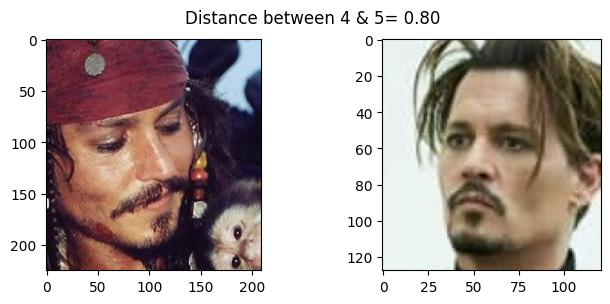

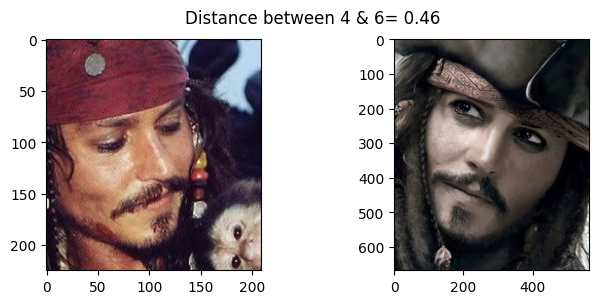

In [136]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance between {idx1} & {idx2}= {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(4, 5)
show_pair(4, 6)

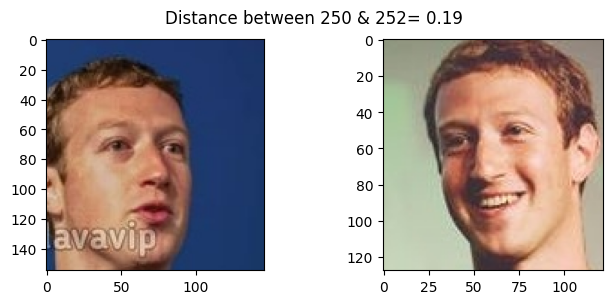

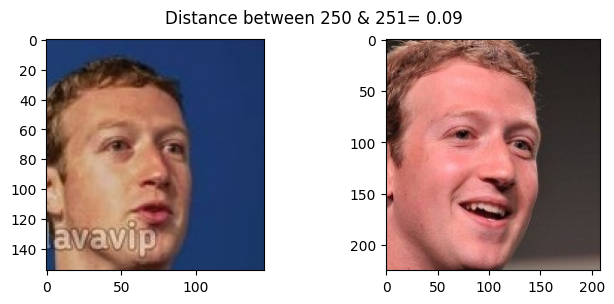

In [174]:
show_pair(250, 252)
show_pair(250, 251)

In [138]:
# show_pair(1407, 1408)
# show_pair(1408, 1602)

<a id = '4.4'></a>
<p style = "font-size:20px; color: #007580 "><strong> 4.4 Create train and test sets </strong></p>
- Create X_train, X_test and y_train, y_test
- Use train_idx to seperate out training features and labels
- Use test_idx to seperate out testing features and labels

In [193]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0     #every 9th example goes in test data and rest go in train data
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]

# another half as test examples of 10 identities
X_test = embeddings[test_idx]
targets = np.array([m.name for m in metadata])

#train labels
y_train = targets[train_idx]

#test labels
y_test = targets[test_idx]

In [194]:
print('X_train shape : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train shape : ({0},)'.format(y_train.shape[0]))
print('X_test shape : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test shape : ({0},)'.format(y_test.shape[0]))

X_train shape : (702,2622)
y_train shape : (702,)
X_test shape : (88,2622)
y_test shape : (88,)


In [195]:
y_test[0], y_train[680]

('pins_Johnny Depp', 'pins_Zendaya')

In [196]:
len(np.unique(y_test)), len(np.unique(y_train))

(5, 5)

<p style = "font-size:20px; color: #007580 "><strong> Encode the Labels </strong></p>
- Encode the targets
- Use LabelEncoder

In [197]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

In [198]:
print(le.classes_)
y_test_encoded = le.transform(y_test)

['pins_Johnny Depp' 'pins_Mark Zuckerberg' 'pins_Selena Gomez'
 'pins_Tom Holland' 'pins_Zendaya']


In [199]:
print('y_train_encoded : ', y_train_encoded)
print('y_test_encoded : ', y_test_encoded)

y_train_encoded :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3

<p style = "font-size:20px; color: #007580 "><strong> Standardize the feature values </strong></p> 
- Scale the features using StandardScaler

In [200]:
# Standarize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [201]:
X_test_std = scaler.transform(X_test)

<a id = '4.5'></a>
<p style = "font-size:20px; color: #007580 "><strong> 4.5 Reduce dimensions using PCA </strong></p> 
- Reduce feature dimensions using Principal Component Analysis
- Set the parameter n_components=128

In [202]:
print('X_train_std shape : ({0},{1})'.format(X_train_std.shape[0], X_train_std.shape[1]))
print('y_train_encoded shape : ({0},)'.format(y_train_encoded.shape[0]))
print('X_test_std shape : ({0},{1})'.format(X_test_std.shape[0], X_test_std.shape[1]))
print('y_test_encoded shape : ({0},)'.format(y_test_encoded.shape[0]))

X_train_std shape : (702,2622)
y_train_encoded shape : (702,)
X_test_std shape : (88,2622)
y_test_encoded shape : (88,)


In [203]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

<a id = '5.0'></a>
<h2 style = "font-size:35px; font-family:Garamond ; font-weight : normal; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> 5. Model Building and Validation </h2> 

<a id = '5.1'></a>
<p style = "font-size:20px; color: #007580 "><strong> 5.1 Build a Machine Learning Classifier </strong></p> 

- Use SVM Classifier to predict the person in the given image
- Fit the classifier and print the score

In [204]:
from sklearn.svm import SVC

clf = SVC(C=5., gamma=0.001)
clf.fit(X_train_pca, y_train_encoded)

SVC(C=5.0, gamma=0.001)

In [205]:
y_predict = clf.predict(X_test_pca)

In [206]:
print('y_predict : ',y_predict)
print('y_test_encoded : ',y_test_encoded)

y_predict :  [1 3 1 0 0 0 0 0 3 0 0 0 3 0 0 3 1 0 0 0 0 3 1 1 3 1 1 3 3 1 1 2 2 2 2 2 2
 2 2 2 4 4 2 2 2 4 2 2 2 2 2 4 0 3 1 3 3 3 0 3 0 0 0 0 3 0 0 3 0 3 1 0 0 2
 0 2 2 2 2 4 4 2 2 4 2 2 4 2]
y_test_encoded :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


In [207]:
y_predict_encoded = le.inverse_transform(y_predict)

In [208]:
print('y_predict_encoded : ',y_predict_encoded)

y_predict_encoded :  ['pins_Mark Zuckerberg' 'pins_Tom Holland' 'pins_Mark Zuckerberg'
 'pins_Johnny Depp' 'pins_Johnny Depp' 'pins_Johnny Depp'
 'pins_Johnny Depp' 'pins_Johnny Depp' 'pins_Tom Holland'
 'pins_Johnny Depp' 'pins_Johnny Depp' 'pins_Johnny Depp'
 'pins_Tom Holland' 'pins_Johnny Depp' 'pins_Johnny Depp'
 'pins_Tom Holland' 'pins_Mark Zuckerberg' 'pins_Johnny Depp'
 'pins_Johnny Depp' 'pins_Johnny Depp' 'pins_Johnny Depp'
 'pins_Tom Holland' 'pins_Mark Zuckerberg' 'pins_Mark Zuckerberg'
 'pins_Tom Holland' 'pins_Mark Zuckerberg' 'pins_Mark Zuckerberg'
 'pins_Tom Holland' 'pins_Tom Holland' 'pins_Mark Zuckerberg'
 'pins_Mark Zuckerberg' 'pins_Selena Gomez' 'pins_Selena Gomez'
 'pins_Selena Gomez' 'pins_Selena Gomez' 'pins_Selena Gomez'
 'pins_Selena Gomez' 'pins_Selena Gomez' 'pins_Selena Gomez'
 'pins_Selena Gomez' 'pins_Zendaya' 'pins_Zendaya' 'pins_Selena Gomez'
 'pins_Selena Gomez' 'pins_Selena Gomez' 'pins_Zendaya'
 'pins_Selena Gomez' 'pins_Selena Gomez' 'pins_Selena 

In [209]:
print('y_predict shape : ', y_predict.shape)
print('y_test_encoded shape : ', y_test_encoded.shape)

y_predict shape :  (88,)
y_test_encoded shape :  (88,)


In [210]:
y_test_encoded[32:49]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [211]:
# Find the classification accuracy
accuracy_score(y_test_encoded, y_predict)

0.5568181818181818

**Accuracy Score: 96.455%**

<a id = '5.2'></a>
<p style = "font-size:20px; color: #007580 "><strong> 5.2 Validate Celebrity Images </strong></p> 

- Take  401th  image from test set and plot the image
- Report to which person(folder name in dataset) the image belongs to

In [222]:
# Load and preprocess the new image

def detect_celeb(image_path):
    # Load and preprocess the new image
    new_image = load_image(image_path)
    new_image = (new_image / 255.).astype(np.float32)
    new_image = cv2.resize(new_image, dsize=(224, 224))

    # Extract embedding for the new image
    new_embedding = vgg_face_descriptor.predict(np.expand_dims(new_image, axis=0))[0]

    # Make a prediction using the SVM classifier
    new_prediction_encoded = clf.predict(pca.transform(scaler.transform(np.expand_dims(new_embedding, axis=0))))

    # Decode the predicted label
    new_identity = le.inverse_transform(new_prediction_encoded)[0]

    # Display the result
    plt.imshow(new_image)
    plt.title(f'Identified as {new_identity}')
    plt.show()

# Usage example:
# detect_celeb('holl.jpg')

1/1 [==============================] - 0s 153ms/step


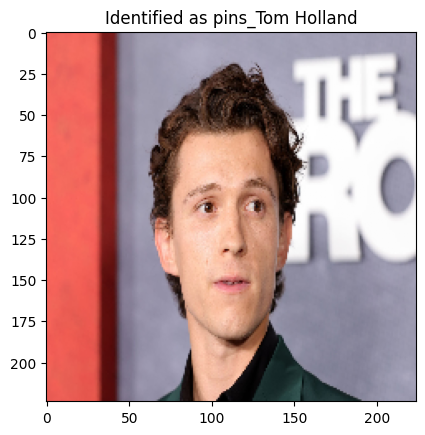

In [223]:
detect_celeb('holl.jpg')

1/1 [==============================] - 0s 180ms/step


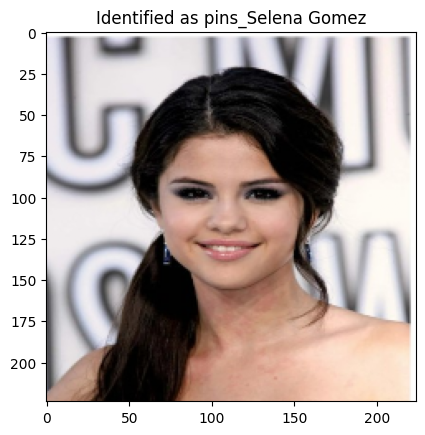

In [224]:
detect_celeb('selena.jpg')